**Step 1: Install Required Packages**

In [ ]:
!pip install pandas numpy matplotlib tensorflow sklearn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sklearn-0.0.post5.tar.gz (3.7 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=6ad0cd1a5879bb27475609a2ac898049c24ffd89e7a5204b2fc8e5c5504f3abe
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn


**Step 2: Import Required Packages**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


**Step 3: Load the Data**

In [ ]:
df = pd.read_csv('BTC-USD.csv')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/BTC-USD.csv"
df = pd.read_csv(path)

Mounted at /content/drive


In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-05-08,35502.941406,35502.941406,33878.964844,34059.265625,34059.265625,36763041910
1,2022-05-09,34060.015625,34222.074219,30296.953125,30296.953125,30296.953125,63355494961
2,2022-05-10,30273.654297,32596.308594,29944.802734,31022.906250,31022.906250,59811038817
3,2022-05-11,31016.183594,32013.402344,28170.414063,28936.355469,28936.355469,70388855818
4,2022-05-12,28936.734375,30032.439453,26350.490234,29047.751953,29047.751953,66989173272


**Step 4: Preprocess the Data**

In [ ]:
# Filter only the relevant columns
df = df[['Date', 'Close']]
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
# Set the 'Date' column as the index
df.set_index('Date', inplace=True)
# Scale the data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


<ipython-input-4-ff24f508167d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


**Step 5: Split the Data into Training and Testing Sets**

In [ ]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_data, test_data = df.iloc[0:train_size,:], df.iloc[train_size:len(df),:]


**Step 6: Prepare the Data for LSTM Model**

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
X_train, y_train = create_dataset(train_data, train_data.Close, time_steps)
X_test, y_test = create_dataset(test_data, test_data.Close, time_steps)


**Step 7: Build the LSTM Model**

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


**Step 8: Train the LSTM Model**

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, shuffle=False)


Epoch 1/100
8/8 [==============================] - 6s 177ms/step - loss: 0.0457 - val_loss: 0.0061
Epoch 2/100
8/8 [==============================] - 0s 39ms/step - loss: 0.0143 - val_loss: 0.0110
Epoch 3/100
8/8 [==============================] - 0s 36ms/step - loss: 0.0099 - val_loss: 0.0176
Epoch 4/100
8/8 [==============================] - 0s 36ms/step - loss: 0.0097 - val_loss: 0.0103
Epoch 5/100
8/8 [==============================] - 0s 35ms/step - loss: 0.0093 - val_loss: 0.0084
Epoch 6/100
8/8 [==============================] - 0s 62ms/step - loss: 0.0086 - val_loss: 0.0106
Epoch 7/100
8/8 [==============================] - 0s 62ms/step - loss: 0.0080 - val_loss: 0.0089
Epoch 8/100
8/8 [==============================] - 1s 64ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 9/100
8/8 [==============================] - 1s 72ms/step - loss: 0.0071 - val_loss: 0.0078
Epoch 10/100
8/8 [==============================] - 1s 64ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 11/100
8/8 [

**Step 9: Make Predictions on Test Data and Evaluate the Model**

2/2 [==============================] - 2s 16ms/step
RMSE: 864.8514137755757


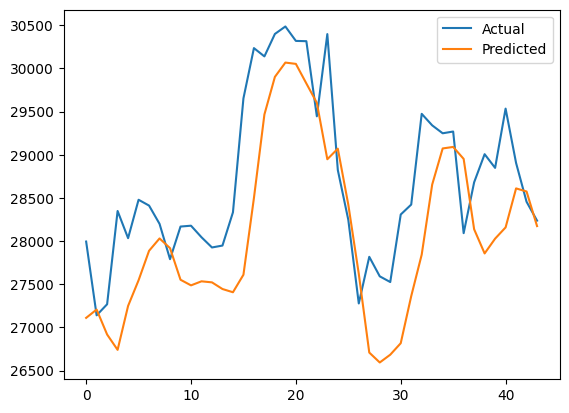

In [ ]:
# Make predictions on test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((y_pred - y_test) ** 2)))
print('RMSE:', rmse)

# Plot the predicted and actual values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()
